0) Setup – Drive + ספריות


In [1]:
# === 0.1 Mount Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 0.2 Imports ===
import os, glob, math, random
import numpy as np
import cv2
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import BernoulliNB


Mounted at /content/drive


In [4]:
BASE = "/content/drive/MyDrive/ImageProcProject/data_raw"
for split in ["train", "test"]:
    for cls in ["walk", "wave"]:
        p = os.path.join(BASE, split, cls)
        print(split, cls, "exists?", os.path.isdir(p), "files:", len(glob.glob(p+"/*")))
        print("  sample:", glob.glob(p+"/*")[:3])


train walk exists? True files: 2
  sample: ['/content/drive/MyDrive/ImageProcProject/data_raw/train/walk/walk1.MOV', '/content/drive/MyDrive/ImageProcProject/data_raw/train/walk/walk2.MOV']
train wave exists? True files: 2
  sample: ['/content/drive/MyDrive/ImageProcProject/data_raw/train/wave/wave1.MOV', '/content/drive/MyDrive/ImageProcProject/data_raw/train/wave/wave2.MOV']
test walk exists? True files: 1
  sample: ['/content/drive/MyDrive/ImageProcProject/data_raw/test/walk/walk3.MP4']
test wave exists? True files: 1
  sample: ['/content/drive/MyDrive/ImageProcProject/data_raw/test/wave/wave3.MP4']


1) טעינת וידאו → פריימים (64×64, Gray)


In [5]:
# מטרה: להפוך כל סרטון ל־Tensor בצורה:
# frames: (T, H, W) עם H=W=64

def load_video_frames(path, size=(64, 64), max_frames=None, every_n=1):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {path}")

    frames = []
    idx = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if idx % every_n == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, size, interpolation=cv2.INTER_AREA)
            frames.append(gray.astype(np.float32))
            if max_frames is not None and len(frames) >= max_frames:
                break
        idx += 1

    cap.release()
    frames = np.stack(frames, axis=0)  # (T, H, W)
    return frames


In [6]:
# דוגמה אחת לראות שזה עובד
sample_vid = glob.glob(os.path.join(BASE, "train", "walk", "*"))[0]
frames = load_video_frames(sample_vid, size=(64,64), every_n=1)
frames.shape, frames.min(), frames.max()


((260, 64, 64), np.float32(1.0), np.float32(240.0))

2) יצירת דוגמאות אימון: בלוקים 5×5×5 סביב פיקסלים “פעילים”


כאן אנחנו מיישמים את רעיון המאמר:
בלוק מרחב־זמן לכל פיקסל (x,y) בזמן t.
כדי לא לעבור על כל פיקסל (זה כבד), אנחנו:
מחשבים תנועה גסה: abs(frame[t] - frame[t-1])
בוחרים פיקסלים שבהם יש תנועה מעל סף
מהם מוציאים בלוקים 5×5×5

In [7]:
def sample_spatiotemporal_blocks(video, block_size=5, motion_thr=15.0, max_blocks=4000, seed=42):
    """
    video: (T,H,W) float32
    returns: blocks (N, bs, bs, bs), and their center coords (t,y,x)
    """
    rng = np.random.default_rng(seed)
    T, H, W = video.shape
    bs = block_size
    r = bs // 2

    # motion map per time (T-1, H, W)
    diff = np.abs(video[1:] - video[:-1])

    # candidates where motion is high
    cand = np.argwhere(diff > motion_thr)  # indices: (t-1, y, x)
    if len(cand) == 0:
        return np.zeros((0, bs, bs, bs), dtype=np.float32), np.zeros((0,3), dtype=np.int32)

    # subsample candidates
    if len(cand) > max_blocks:
        cand = cand[rng.choice(len(cand), size=max_blocks, replace=False)]

    blocks = []
    coords = []
    for (t0, y, x) in cand:
        t = t0 + 1  # center time
        # boundary check for block extraction
        if t-r < 0 or t+r >= T:
            continue
        if y-r < 0 or y+r >= H:
            continue
        if x-r < 0 or x+r >= W:
            continue

        cube = video[t-r:t+r+1, y-r:y+r+1, x-r:x+r+1]  # (bs, bs, bs) but order = (time, y, x)
        # we want (y,x,time) or (time,y,x) consistently; for DCT3D order doesn't matter if consistent
        # let's keep (time, y, x)
        blocks.append(cube)
        coords.append((t, y, x))

    if len(blocks) == 0:
        return np.zeros((0, bs, bs, bs), dtype=np.float32), np.zeros((0,3), dtype=np.int32)

    blocks = np.stack(blocks, axis=0).astype(np.float32)  # (N, bs, bs, bs)
    coords = np.array(coords, dtype=np.int32)
    return blocks, coords


3) 3D DCT על בלוק + “נרמול” (כמו במאמר)


In [8]:
# Try SciPy DCT
try:
    from scipy.fft import dctn
    def dct3(block):
        # block: (bs,bs,bs)
        return dctn(block, norm='ortho')
    SCIPY_OK = True
except:
    SCIPY_OK = False
    print("SciPy not available. We'll use a slower fallback.")

    def dct1d(x, axis=-1):
        # simple cosine transform fallback (not super fast)
        x = np.swapaxes(x, axis, -1)
        N = x.shape[-1]
        n = np.arange(N)
        k = n.reshape(-1,1)
        cos = np.cos(np.pi*(n+0.5)*k/N)
        y = x @ cos.T
        y = np.swapaxes(y, axis, -1)
        return y

    def dct3(block):
        out = dct1d(block, axis=0)
        out = dct1d(out, axis=1)
        out = dct1d(out, axis=2)
        return out


In [9]:
# וקטור פיצ׳רים רציף מכל בלוק
def block_to_dct_vector(block, eps=1e-6):
    # normalize block
    b = block.astype(np.float32)
    b = b - b.mean()
    b = b / (b.std() + eps)

    coeff = dct3(b)               # (bs,bs,bs)
    v = np.abs(coeff).reshape(-1) # flatten absolute values
    return v


4) בניית דאטהסט אימון/טסט: X רציף + y


In [10]:
def collect_dataset(split, classes=("walk","wave"),
                    size=(64,64), every_n=1,
                    block_size=5, motion_thr=15.0, max_blocks_per_video=3000):

    X = []
    y = []
    meta = []  # (video_path, Nblocks)

    for cls in classes:
        paths = sorted(glob.glob(os.path.join(BASE, split, cls, "*")))
        label = 1 if cls == "walk" else 0  # למשל: walk=1, wave=0

        for vp in tqdm(paths, desc=f"{split}/{cls}"):
            vid = load_video_frames(vp, size=size, every_n=every_n)
            blocks, _ = sample_spatiotemporal_blocks(
                vid, block_size=block_size, motion_thr=motion_thr, max_blocks=max_blocks_per_video
            )
            if len(blocks) == 0:
                meta.append((vp, 0))
                continue

            # convert blocks to DCT vectors
            for b in blocks:
                X.append(block_to_dct_vector(b))
                y.append(label)
            meta.append((vp, len(blocks)))

    X = np.stack(X, axis=0) if len(X) else np.zeros((0, block_size**3), dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    return X, y, meta


In [11]:
X_train_cont, y_train, meta_train = collect_dataset(
    "train", block_size=5, motion_thr=15.0, max_blocks_per_video=2500
)
X_test_cont, y_test, meta_test = collect_dataset(
    "test", block_size=5, motion_thr=15.0, max_blocks_per_video=2500
)

X_train_cont.shape, X_test_cont.shape, (y_train.mean(), y_test.mean())


test/wave: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


((9392, 125),
 (4790, 125),
 (np.float64(0.48434838160136284), np.float64(0.49164926931106473)))

5) בחירת פיצ’רים לפי Mutual Information + בחירת ספים (כמו במאמר)


In [12]:
def mutual_information_binary(x_bin, y_bin, eps=1e-12):
    """
    x_bin, y_bin: arrays of 0/1
    returns MI(x;y)
    """
    x = x_bin.astype(np.int32)
    y = y_bin.astype(np.int32)
    n = len(x)

    p11 = np.mean((x==1)&(y==1))
    p10 = np.mean((x==1)&(y==0))
    p01 = np.mean((x==0)&(y==1))
    p00 = np.mean((x==0)&(y==0))

    px1 = p11+p10
    px0 = p01+p00
    py1 = p11+p01
    py0 = p10+p00

    mi = 0.0
    for pxy, px, py in [(p11, px1, py1), (p10, px1, py0), (p01, px0, py1), (p00, px0, py0)]:
        if pxy > 0:
            mi += pxy * math.log((pxy+eps)/((px+eps)*(py+eps)) + eps)
    return mi


In [13]:
# בחירת סף לכל פיצ׳ר מתוך גריד
def select_thresholds_and_topk(X_cont, y, num_bins=40, topk=30):
    """
    X_cont: (N, F) abs(DCT coeffs)
    returns:
      selected_idx: indices of chosen features
      selected_thr: threshold per chosen feature
      mi_scores: MI of chosen features
    """
    N, F = X_cont.shape
    ybin = y.copy()

    # thresholds candidates: per feature use quantiles to be stable
    thr_grid = np.linspace(0.05, 0.95, num_bins)

    best_thr = np.zeros(F, dtype=np.float32)
    best_mi = np.zeros(F, dtype=np.float32)

    # For speed: subsample
    if N > 50000:
        idx = np.random.choice(N, 50000, replace=False)
        Xs = X_cont[idx]
        ys = ybin[idx]
    else:
        Xs, ys = X_cont, ybin

    for f in tqdm(range(F), desc="Selecting thresholds per feature"):
        xf = Xs[:, f]
        # candidate thresholds based on quantiles
        qs = np.quantile(xf, thr_grid)

        mi_max = -1.0
        thr_max = qs[0]
        for thr in qs:
            x_bin = (xf >= thr).astype(np.int32)
            mi = mutual_information_binary(x_bin, ys)
            if mi > mi_max:
                mi_max = mi
                thr_max = thr
        best_thr[f] = thr_max
        best_mi[f] = mi_max

    # pick top-k features
    top_idx = np.argsort(-best_mi)[:topk]
    return top_idx, best_thr[top_idx], best_mi[top_idx]


In [15]:
# הרצה על train
# חשוב: X_train_cont כבר abs(DCT) כי עשינו abs בתוך block_to_dct_vector
feat_idx, feat_thr, feat_mi = select_thresholds_and_topk(
    X_train_cont, y_train, num_bins=30, topk=30
)
feat_idx[:10], feat_thr[:10], feat_mi[:10]


Selecting thresholds per feature: 100%|██████████| 125/125 [00:01<00:00, 77.31it/s]


(array([110, 120, 115, 105,  80,  85, 111, 116, 121,  55]),
 array([0.13687108, 0.08353452, 0.09812827, 0.1359594 , 0.33478174,
        0.22845715, 0.19734071, 0.13034642, 0.10576543, 0.61274886],
       dtype=float32),
 array([0.12228878, 0.12123363, 0.11963272, 0.11337641, 0.1108833 ,
        0.11053551, 0.10970426, 0.10654986, 0.10576542, 0.10266889],
       dtype=float32))

6) המרה לבינארי + אימון Naive Bayes


In [16]:
def binarize_selected(X_cont, feat_idx, feat_thr):
    Xsel = X_cont[:, feat_idx]
    Xbin = (Xsel >= feat_thr.reshape(1, -1)).astype(np.int8)
    return Xbin

X_train_bin = binarize_selected(X_train_cont, feat_idx, feat_thr)
X_test_bin  = binarize_selected(X_test_cont,  feat_idx, feat_thr)

model = BernoulliNB(alpha=1.0)
model.fit(X_train_bin, y_train)

pred = model.predict(X_test_bin)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=["wave(0)","walk(1)"]))
print(confusion_matrix(y_test, pred))


Accuracy: 0.8872651356993737
              precision    recall  f1-score   support

     wave(0)       0.98      0.79      0.88      2435
     walk(1)       0.82      0.99      0.90      2355

    accuracy                           0.89      4790
   macro avg       0.90      0.89      0.89      4790
weighted avg       0.90      0.89      0.89      4790

[[1929  506]
 [  34 2321]]


7) סיווג ברמת וידאו (Majority Vote) – מקצועי להגשה


In [17]:
def predict_video_level(split):
    results = []
    for cls in ["walk","wave"]:
        paths = sorted(glob.glob(os.path.join(BASE, split, cls, "*")))
        true_label = 1 if cls=="walk" else 0

        for vp in paths:
            vid = load_video_frames(vp, size=(64,64), every_n=1)
            blocks, _ = sample_spatiotemporal_blocks(vid, block_size=5, motion_thr=15.0, max_blocks=4000)
            if len(blocks)==0:
                results.append((vp, true_label, None, 0))
                continue

            Xc = np.stack([block_to_dct_vector(b) for b in blocks], axis=0)
            Xb = binarize_selected(Xc, feat_idx, feat_thr)
            pb = model.predict_proba(Xb)[:,1]  # prob walk

            vote = int(np.mean(pb) >= 0.5)     # majority by prob
            results.append((vp, true_label, vote, len(blocks)))
    return results

vid_results = predict_video_level("test")
vid_results


[('/content/drive/MyDrive/ImageProcProject/data_raw/test/walk/walk3.MP4',
  1,
  1,
  3794),
 ('/content/drive/MyDrive/ImageProcProject/data_raw/test/wave/wave3.MP4',
  0,
  0,
  3905)]

8) ויזואליזציה צבעונית: “איפה” המודל רואה walk / wave


In [18]:
def overlay_classification(video_path, out_path=None, stride=2, motion_thr=15.0, conf_ratio=2.0):
    vid = load_video_frames(video_path, size=(64,64), every_n=1)
    T,H,W = vid.shape
    bs=5; r=bs//2

    # output video writer (optional)
    out_frames = []

    for t in range(r, T-r):
        frame = vid[t].copy()
        frame_rgb = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_GRAY2BGR)

        # motion gate
        diff = np.abs(vid[t] - vid[t-1])

        for y in range(r, H-r, stride):
            for x in range(r, W-r, stride):
                if diff[y,x] < motion_thr:
                    continue

                cube = vid[t-r:t+r+1, y-r:y+r+1, x-r:x+r+1]
                Xc = block_to_dct_vector(cube).reshape(1,-1)
                Xb = binarize_selected(Xc, feat_idx, feat_thr)

                proba = model.predict_proba(Xb)[0]
                # confidence heuristic: winner >= conf_ratio * loser
                winner = np.argmax(proba)
                if proba[winner] < conf_ratio * proba[1-winner]:
                    continue

                # winner 1=walk, 0=wave
                if winner == 1:
                    # walk -> purple-ish (BGR)
                    frame_rgb[y, x] = (180, 0, 180)
                else:
                    # wave -> yellow-ish (BGR)
                    frame_rgb[y, x] = (0, 220, 220)

        out_frames.append(frame_rgb)

    # show a few frames
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    for i, idx in enumerate([0, len(out_frames)//2, len(out_frames)-1]):
        plt.subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(out_frames[idx], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"t={idx}")
    plt.show()

    return out_frames


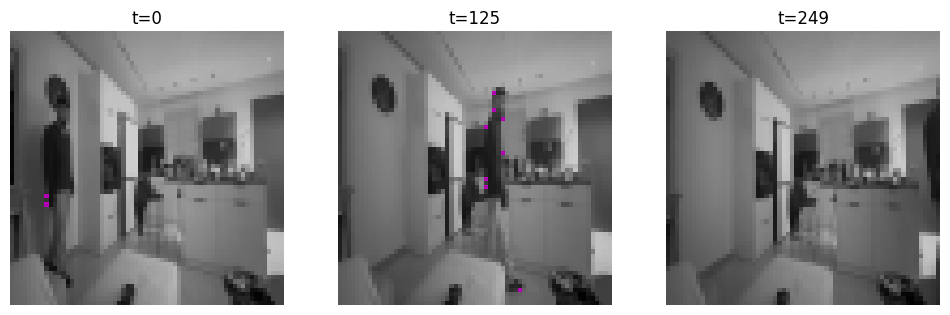

In [19]:
test_vid = glob.glob(os.path.join(BASE, "test", "walk", "*"))[0]
_ = overlay_classification(test_vid, stride=2, motion_thr=15.0, conf_ratio=2.0)


שיפור “מקורי” קטן אבל חכם (שייתן לך ניקוד על Improvements)

Improvement A (מומלץ): “Multi-scale” בזמן

במקום רק every_n=1, ננסה גם every_n=2 (דילוג פריימים) → זה יוצר “תנועה גסה” יותר.

ואז נשווה תוצאות.

In [20]:
# train/eval with every_n=2
X_train2, y_train2, _ = collect_dataset("train", every_n=2, block_size=5, motion_thr=15.0, max_blocks_per_video=2500)
X_test2,  y_test2,  _ = collect_dataset("test",  every_n=2, block_size=5, motion_thr=15.0, max_blocks_per_video=2500)

feat_idx2, feat_thr2, feat_mi2 = select_thresholds_and_topk(X_train2, y_train2, num_bins=30, topk=30)
Xtr2 = binarize_selected(X_train2, feat_idx2, feat_thr2)
Xte2 = binarize_selected(X_test2,  feat_idx2, feat_thr2)

m2 = BernoulliNB(alpha=1.0).fit(Xtr2, y_train2)
pred2 = m2.predict(Xte2)
print("Accuracy every_n=2:", accuracy_score(y_test2, pred2))


Selecting thresholds per feature: 100%|██████████| 125/125 [00:00<00:00, 149.99it/s]


Accuracy every_n=2: 0.8824267782426778


🔧 שדרוג #2 – ניתוח השפעת גודל הבלוק המרחבי־זמני (Block Size Analysis)


In [21]:
# ===== Block size 3x3x3 =====

X_train_3, y_train_3, _ = collect_dataset(
    "train",
    block_size=3,
    motion_thr=15.0,
    max_blocks_per_video=2500
)

X_test_3, y_test_3, _ = collect_dataset(
    "test",
    block_size=3,
    motion_thr=15.0,
    max_blocks_per_video=2500
)

feat_idx_3, feat_thr_3, feat_mi_3 = select_thresholds_and_topk(
    X_train_3, y_train_3,
    num_bins=30,
    topk=30
)

Xtr3 = binarize_selected(X_train_3, feat_idx_3, feat_thr_3)
Xte3 = binarize_selected(X_test_3,  feat_idx_3, feat_thr_3)

model_3 = BernoulliNB(alpha=1.0)
model_3.fit(Xtr3, y_train_3)

pred_3 = model_3.predict(Xte3)

print("Accuracy block 3x3x3:", accuracy_score(y_test_3, pred_3))
print(classification_report(y_test_3, pred_3, target_names=["wave(0)", "walk(1)"]))
print(confusion_matrix(y_test_3, pred_3))


Selecting thresholds per feature: 100%|██████████| 27/27 [00:00<00:00, 111.69it/s]

Accuracy block 3x3x3: 0.8480162767039674
              precision    recall  f1-score   support

     wave(0)       0.91      0.77      0.84      2479
     walk(1)       0.80      0.93      0.86      2436

    accuracy                           0.85      4915
   macro avg       0.86      0.85      0.85      4915
weighted avg       0.86      0.85      0.85      4915

[[1914  565]
 [ 182 2254]]


ניסיון שיפור נוסף

🎯 Video-level accuracy (majority vote / mean probability)


In [30]:
from sklearn.metrics import accuracy_score

def evaluate_with_confidence(X_bin, y, model, ratio_thr=1.0):
    """
    ratio_thr: דרישת ביטחון. לדוגמה 2.0 = המחלקה המנצחת לפחות פי 2 מהשניה
    מחזיר: accuracy על דוגמאות מסווגות בלבד + coverage
    """
    proba = model.predict_proba(X_bin)  # (N,2)
    p0 = proba[:,0]
    p1 = proba[:,1]
    winner = (p1 >= p0).astype(int)

    # ratio of winner/loser
    win_prob = np.maximum(p0, p1)
    lose_prob = np.minimum(p0, p1) + 1e-12
    ratio = win_prob / lose_prob

    mask = ratio >= ratio_thr
    if mask.sum() == 0:
        return None

    acc = accuracy_score(y[mask], winner[mask])
    coverage = mask.mean()
    return acc, coverage, mask.sum()


In [31]:
ratios = [1.0, 1.2, 1.5, 2.0, 3.0, 5.0]

for r in ratios:
    out = evaluate_with_confidence(X_test_bin, y_test, model, ratio_thr=r)
    if out is None:
        print("ratio", r, "-> no classified blocks")
        continue
    acc, cov, n = out
    print(f"ratio_thr={r:>3}  acc={acc:.4f}  coverage={cov:.3f}  classified_blocks={n}")


ratio_thr=1.0  acc=0.8873  coverage=1.000  classified_blocks=4790
ratio_thr=1.2  acc=0.8877  coverage=0.999  classified_blocks=4783
ratio_thr=1.5  acc=0.8889  coverage=0.996  classified_blocks=4770
ratio_thr=2.0  acc=0.8902  coverage=0.992  classified_blocks=4752
ratio_thr=3.0  acc=0.8916  coverage=0.988  classified_blocks=4734
ratio_thr=5.0  acc=0.8938  coverage=0.983  classified_blocks=4707


In [32]:
# Re-collect test with a higher motion threshold (same model pipeline)
X_test_cont_22, y_test_22, _ = collect_dataset("test", block_size=5, motion_thr=22.0, max_blocks_per_video=2500)
X_test_bin_22 = binarize_selected(X_test_cont_22, feat_idx, feat_thr)

pred22 = model.predict(X_test_bin_22)
print("Accuracy motion_thr=22:", accuracy_score(y_test_22, pred22))
print(confusion_matrix(y_test_22, pred22))


test/wave: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Accuracy motion_thr=22: 0.8962978544383677
[[1991  448]
 [  45 2270]]
